# Pêndulo Invertido Duplo - Controlador Não Linear - Módulo doMPC 

Este notebook utiliza os três módulos que constituem o doMPC, template_model.py que descreve o modelo do sistema, template_mpc.py, que define as configurações para o controle, e template_simulator.py, que define os parâmetros para o simulador. Os módulos são usados em main.py para a execução do controlador em malha fechada. 

In [1312]:
# importando os módulos necessários
import numpy as np
import sys
from casadi import *
import matplotlib.pyplot as plt

import do_mpc
import scienceplots  # Para aplicar estilos de formatação científica aos gráficos.
import latex         # Para renderizar texto e equações usando LaTeX nos gráficos.

plt.style.use(['science'])

### Modelo da planta

<center>
<div class=figure >
<img src ="/workspaces/Projeto_TCC_DPI_Thalyson/utils/imagens/Sistema.png"
width= 300> 
<p>Figura 1 - Sistema.</p>
</div>
<center>

O sistema é descrito em termos de sua posição horizontal $x$ e dos dois ângulos $\phi$, onde $\phi_1=\phi_2=0$ definie a posição vertical. 

A partir do modelo dinâmico contínuo do sistema, inicia-se a instância $\textbf{Model}$ do-mpc:

In [1313]:
model_type = 'continuous' # pode ser 'discrete' ou 'continuous'
model = do_mpc.model.Model(model_type)

In [1314]:
# Parâmetros físicos do modelo

m0 = 1 # kg, massa do carrinho.
m1 = 1 # kg, massa da primeira haste (pêndulo inferior).
m2 = 1 # kg, massa da segunda haste (pêndulo superior).
L1 = 0.5 # m, comprimento da primeira haste.
L2 = 0.5 # m, comprimento da segunda haste.
g = 9.80665 # m/s², aceleração da gravidade.

f0 = 0.01 # Coeficiente de atrito viscoso do carrinho. 
f1 = 0.007 # Coeficiente de atrito viscoso do pêndulo inferior. 
f2 = 0.007 # Coeficiente de atrito viscoso do pêndulo superior.

l1 = L1/2 # m:
l2 = L2/2 # m

J1 = (m1*l1**2)/3 # Inércia:
J2 = (m2*l2**2)/3 # Inércia: 

In [1315]:
# Equações de Euler - Lagrange 

a0 = m0 + m1 + m2
a1 = l1*m1 + L1*m2
a2 = m2*l2

a3 = m1*l1**2 + J1 + 4*m2*l1**2
a4 = 2*m2*l1*l2
a5= m2*l2**2 + J2

w1 = g*l1*(m1 + 2*m2)
w2 = g*m2*l2

$$
\begin{align} 
    \left\{\begin{matrix}
    a_0\ddot{x}+ a_1\ddot{\phi_1}\cos(\phi_1)  +a_2\ddot{\phi_2}\cos(\phi_2) - a_1\dot{\phi_1}^2\sin(\phi_1) -a_2\dot{\phi_2}^2\sin(\phi_2) =u-f_0 \dot{x} \\ a_1\ddot{x} \cos(\phi_1)    + a_3\ddot{\phi_1} +a_4\ddot{\phi_2}\cos(\phi_1-\phi_2) +a_4\dot{\phi_2}^2\sin(\phi_1-\phi_2) +a_0 g\sin(\phi_1) =-(f_1 + f_2)\dot{\phi_1} + f_2 \dot{\phi_2}  \\ a_2\ddot{x}\cos(\phi_2)+a_4\ddot{\phi_1}\cos(\phi_1-\phi_2)+a_5\ddot{\phi_2} - a_4\dot{\phi_1}^2 \sin(\phi_1-\phi_2)- a_2g\sin(\phi_2) =f_2\dot{\phi_1} - f_2 \dot{\phi_2} 
    \end{matrix}\right. 
\end{align} 
$$

Os estados $ x= [x, \phi_1, \phi_2, \dot{x}, \dot{\phi_1},\dot{\phi_2}]^T$
e a entrada $u=f$ que é a força horizontal aplicada ao carro.

In [1316]:
# Define as variáveis do modelo e a entrada de controle

pos = model.set_variable('_x', 'pos')

#phi = model.set_variable('_x', 'phi', (2,1))
phi_1 = model.set_variable('_x', 'phi_1')
phi_2 = model.set_variable('_x', 'phi_2')

dpos = model.set_variable('_x', 'dpos')

#dphi = model.set_variable('_x', 'dphi', (2,1))
dphi_1 = model.set_variable('_x', 'dphi_1')
dphi_2 = model.set_variable('_x', 'dphi_2')

u = model.set_variable('_u', 'force')

### Differential algebric equation (DAE)

Introduzindo novos estados algébricos:
$$
z = [\ddot{x}, \ddot{\phi_1}, \ddot{\phi_1}]^T
$$

In [1317]:
ddpos = model.set_variable('_z', 'ddpos')
#ddphi = model.set_variable('_z', 'ddphi', (2,1))
ddphi_1 = model.set_variable('_z', 'ddphi_1')
ddphi_2 = model.set_variable('_z', 'ddphi_2')

É conveniente reformular a ODE em termos de $x,u,z$ na seguinte forma:
$$
\dot{x}=[\dot{x}, \dot{\phi_1}, \dot{\phi_1},\ddot{x}, \ddot{\phi_1}, \ddot{\phi_1}]^T
$$

In [1318]:
# Constroi equações em espaço de estados

model.set_rhs('pos', dpos)
#model.set_rhs('phi', dphi)
model.set_rhs('phi_1', dphi_1)
model.set_rhs('phi_2', dphi_2)
model.set_rhs('dpos', ddpos)
#model.set_rhs('dphi', ddphi)
model.set_rhs('dphi_1', ddphi_1)
model.set_rhs('dphi_2', ddphi_2)


In [1319]:
"""euler_lagrange = vertcat(
    #1
    a0*ddpos + a1*ddphi[0]*cos(phi[0]) + a2*ddphi[1]*cos(phi[1])
    + f0*dpos - a1*dphi[0]**2*sin(phi[0]) + a3*dphi[1]**2*sin(phi[1]) - u,

    #2
    a1*cos(phi[0])*ddpos + a3*ddphi[0] + a4*cos(phi[0]-phi[1])*ddphi[1]
    +a4*dphi[1]**2*sin(phi[0]-phi[1]) - w1*sin(phi[0]) - f2*dphi[1] + (f1+f2)*dphi[0] ,
    
    #3
    a2*cos(phi[1])*ddpos + a4*cos(phi[0]-phi[1])*ddphi[0] + a5*ddphi[1]
    - a4*dphi[0]**2*sin(phi[0]-phi[1]) - w2*sin(phi[1]) + f2*dphi[0] - f2*dphi[1]
    )
model.set_alg('euler-lagrange', euler_lagrange)"""

"euler_lagrange = vertcat(\n    #1\n    a0*ddpos + a1*ddphi[0]*cos(phi[0]) + a2*ddphi[1]*cos(phi[1])\n    + f0*dpos - a1*dphi[0]**2*sin(phi[0]) + a3*dphi[1]**2*sin(phi[1]) - u,\n\n    #2\n    a1*cos(phi[0])*ddpos + a3*ddphi[0] + a4*cos(phi[0]-phi[1])*ddphi[1]\n    +a4*dphi[1]**2*sin(phi[0]-phi[1]) - w1*sin(phi[0]) - f2*dphi[1] + (f1+f2)*dphi[0] ,\n    \n    #3\n    a2*cos(phi[1])*ddpos + a4*cos(phi[0]-phi[1])*ddphi[0] + a5*ddphi[1]\n    - a4*dphi[0]**2*sin(phi[0]-phi[1]) - w2*sin(phi[1]) + f2*dphi[0] - f2*dphi[1]\n    )\nmodel.set_alg('euler-lagrange', euler_lagrange)"

In [1320]:
euler_lagrange = vertcat(
    #1
    a0*ddpos + a1*ddphi_1*cos(phi_1) + a2*ddphi_2*cos(phi_2)
    + f0*dpos - a1*dphi_1**2*sin(phi_1) + a3*dphi_2**2*sin(phi_2) - u,

    #2
    a1*cos(phi_1)*ddpos + a3*ddphi_1 + a4*cos(phi_1-phi_2)*ddphi_2
    +a4*dphi_2**2*sin(phi_1-phi_2) - w1*sin(phi_1) - f2*dphi_2 + (f1+f2)*dphi_1 ,
    
    #3
    a2*cos(phi_2)*ddpos + a4*cos(phi_1-phi_2)*ddphi_1 + a5*ddphi_2
    - a4*dphi_1**2*sin(phi_1-phi_2) - w2*sin(phi_2) + f2*dphi_1 - f2*dphi_2
    )
model.set_alg('euler-lagrange', euler_lagrange)

### Equações de Energia

Par seguimendo na formulação do MPC, introduziresmos expressões auxiliares de energia cinética e potencial do sistema.

Para a energia cinética, temos:
$$
\begin{gather*} 
    K_c =\frac{1}{2} M \dot{x}^2 
\\
     K_{m_1} = \frac{1}{2}m_1\left ( \dot{x}+\dot{\phi_1}l_1 \cos(\phi_1)\right )^2+\frac{1}{2}m_1\left ( \dot{\phi_1}l_1 \sin(\phi_1) \right )^2 + \frac{1}{2}J_1 \dot{\phi_1}^2 
\end{gather*}
$$
$$
\begin{align*}
     K_{m_2}=\frac{1}{2}m_2\left ( \dot{x}+2l_1\cos(\phi_1)\dot{\phi_1}+l_2\cos(\phi_2)\dot{\phi_2} \right )^2 + \\ \frac{1}{2}m_2\left (2l_1\sin(\phi_1)\dot{\phi_1}+l_2\sin(\phi_2)\dot{\phi_2} \right )^2 + \frac{1}{2}J_2\dot{\phi_2}^2
\end{align*}  
$$

Energia potencial total:

$$
\begin{align*}
    P = m_1gl_1 \cos(\phi_1) + m_2g(2l_1 \cos(\phi_1)+l_2\cos(\phi_2))
\end{align*}
$$

In [1321]:
"""E_c = 1/2 * m0 * dpos**2

E_p1 =1 / 2 * m1 * (
    (dpos + l1 * dphi[0] * cos(phi[0]))**2 +
    (l1 * dphi[0] * sin(phi[0]))**2) + 1 / 2 * J1 * dphi[0]**2

E_p2 = 1 / 2 * m2 * (
    (dpos + L1 * dphi[0] * cos(phi[0]) + l2 * dphi[1] * cos(phi[1]))**2 +
    (L1 * dphi[0] * sin(phi[0]) + l2 * dphi[1] * sin(phi[1]))**
    2) + 1 / 2 * J2 * dphi[0]**2

E_ct = E_c + E_p1 + E_p2

#print(E_ct)
E_pot = m1*g*l1*cos(phi[0]) + m2*g*(2*l1*cos(phi[0])+
              l2*cos(phi[1]))
"""
E_c = 1/2 * m0 * dpos**2

E_p1 =1 / 2 * m1 * (
    (dpos + l1 * dphi_1 * cos(phi_1))**2 +
    (l1 * dphi_1 * sin(phi_1))**2) + 1 / 2 * J1 * dphi_1**2

E_p2 = 1 / 2 * m2 * (
    (dpos + L1 * dphi_1 * cos(phi_1) + l2 * dphi_2 * cos(phi_2))**2 +
    (L1 * dphi_1 * sin(phi_1) + l2 * dphi_2 * sin(phi_2))**
    2) + 1 / 2 * J2 * dphi_1**2

E_ct = E_c + E_p1 + E_p2

#print(E_ct)
E_pot = m1*g*l1*cos(phi_1) + m2*g*(2*l1*cos(phi_1)+
              l2*cos(phi_2))

model.set_expression('E_ct', E_ct)
model.set_expression('E_pot', E_pot)

SX(((2.45166*cos(phi_1))+(9.80665*((0.5*cos(phi_1))+(0.25*cos(phi_2))))))

In [1322]:
# Finaliza e constroi o modelo
model.setup()

### Controlador
Agora, o contolador será configurado. Passamos o objeto $\textbf{model}$ definido anteriormente como argumento pois o controlador precisa de um modelo matemático do sistema para funcionar.

In [1323]:
mpc = do_mpc.controller.MPC(model)

Configuramos os de parâmetros essenciais para o funcionamento do controlador MPC, definindo como e até que ponto no futuro ele deve fazer suas previsões.

In [1324]:
setup_mpc = {
    'n_horizon': 45,
    'n_robust': 1,
    'open_loop': 0,
    't_step': 0.02,
    'state_discretization': 'collocation',
    'collocation_type': 'radau',
    'collocation_deg': 3,
    'collocation_ni': 1,
    'store_full_solution': True,
    # Use MA27 linear solver in ipopt for faster calculations:
    'nlpsol_opts': {'ipopt.linear_solver': 'mumps'}
}
mpc.set_param(**setup_mpc)

### Função Custo

O objetivo do controle é erguer o pêndulo duplo e estabilizá-lo na posição para cima. Não é fácil formular um objetivo que produza esse resultado. 

Nesse caso, usaremos uma formulação baseada em energia para o objetivo. Se pensarmos em energia em termos de energia potencial e cinética, fica claro que queremos maximizar a energia potencial (posição para cima) e minimizar a energia cinética (estabilização).

Como já introduzimos as expressões para a energia potencial e cinética no modelo, agora podemos simplesmente reutilizar essas expressões para a formulação da função objetivo, conforme mostrado abaixo:

A formulação MPC é, em sua essência, um problema de otimização para o qual precisamos definir uma função objetivo:

In [1325]:
mterm = model.aux['E_ct'] - model.aux['E_pot'] #custo terminal (mterm). Penalidade aplicada apenas no estado final do horizonte de predição. 
lterm = model.aux['E_ct'] - model.aux['E_pot'] #custo de estágio (lterm).Penalidade aplicada em cada passo do horizonte de predição. 
"""mterm = pos**2 + phi[0]**2+phi[1]**2
lterm = pos**2 + phi[0]**2+phi[1]**2"""
#mterm = pos**2 + phi_1**2+phi_2**2
#lterm = 200*(pos**2 + phi_1**2+phi_2**2)

mpc.set_objective(mterm=mterm, lterm=lterm)
mpc.set_rterm(force=0.01) # Penalidade sobre o uso da entrada de controle. 

### Restrições

In [1326]:
mpc.bounds['lower','_u','force'] = -47 # limite inferior para a entrada de controle (_u)
mpc.bounds['upper','_u','force'] = 47# limite superior para a entrada de controle (_u)

In [1327]:
mpc.setup()

### Estimador

Assumindo que todos os estados podem ser medidos diretamente e com perfeição em cada instante.

In [1328]:
estimator = do_mpc.estimator.StateFeedback(model)

### Simulador

Para criar as simulações do MPC em malha fechada, cria-se um instância do simulador do módulo que é baseado no modelo. 

In [1329]:
simulator = do_mpc.simulator.Simulator(model) # Instacia o Simulator (baseado no mesmo modelo)
params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'idas', # Solver robusto para DAES
    'abstol': 1e-8, # tolerância absoluta
    'reltol': 1e-8, # tolerância relativa
    't_step': 0.02 # passo de tempo da simulação em segundos
}

simulator.set_param(**params_simulator)

In [1330]:
simulator.setup()

### Simulação em malha fechada

In [1331]:
#simulator.x0['phi'] = 0.99*np.pi # Estado inicial (x0) do sistema no simulador.
simulator.x0['phi_1'] = 0.99*np.pi #np.deg2rad(5)# 0.99*np.pi # Estado inicial (x0) do sistema no simulador.
simulator.x0['phi_2'] = 0.99*np.pi #np.deg2rad(5)# 0.99*np.pi # Estado inicial (x0) do sistema no simulador.
simulator.x0['pos'] = 0.0

x0 = simulator.x0.cat.full()

mpc.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

In [1332]:
plt.ion()
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 1.5
rcParams['axes.labelsize'] = 'xx-large'
rcParams['xtick.labelsize'] = 'xx-large'
rcParams['ytick.labelsize'] = 'xx-large'

In [1333]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)

In [1334]:
def pendulum_bars(x):
    x = x.flatten()
    # Get the x,y coordinates of the two bars for the given state x.
    line_1_x = np.array([
        x[0],
        x[0]+L1*np.sin(x[1])
    ])

    line_1_y = np.array([
        0,
        L1*np.cos(x[1])
    ])

    line_2_x = np.array([
        line_1_x[1],
        line_1_x[1] + L2*np.sin(x[2])
    ])

    line_2_y = np.array([
        line_1_y[1],
        line_1_y[1] + L2*np.cos(x[2])
    ])

    line_1 = np.stack((line_1_x, line_1_y))
    line_2 = np.stack((line_2_x, line_2_y))

    return line_1, line_2

C:\Users\mateu\AppData\Local\Temp\ipykernel_17748\498255573.py:44: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  fig.tight_layout()


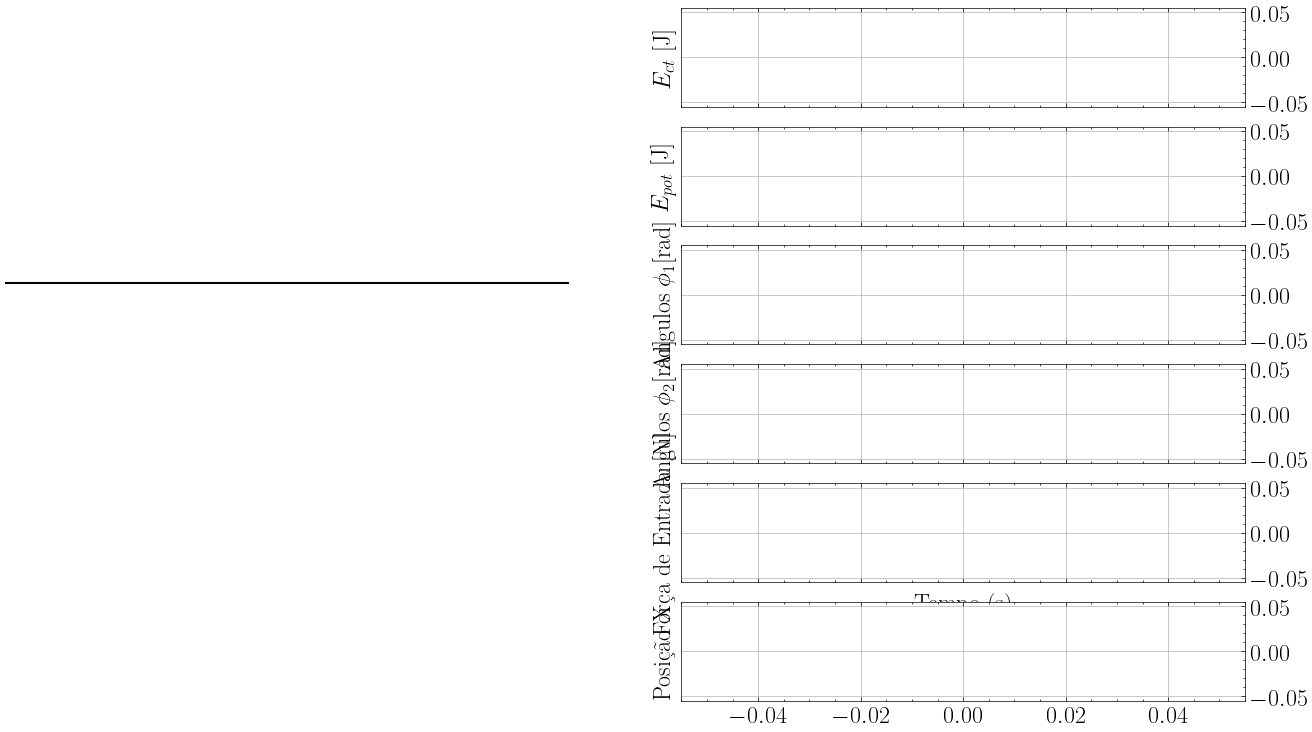

In [1335]:
fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot2grid((5, 2), (0, 0), rowspan=4)
ax2 = plt.subplot2grid((6, 2), (0, 1))
ax3 = plt.subplot2grid((6, 2), (1, 1))
ax4 = plt.subplot2grid((6, 2), (2, 1))
ax5 = plt.subplot2grid((6, 2), (3, 1))
ax6 = plt.subplot2grid((6, 2), (4, 1))
ax7 = plt.subplot2grid((6, 2), (5, 1))

ax2.set_ylabel('$E_{ct}$ [J]')
ax3.set_ylabel('$E_{pot}$ [J]')
ax4.set_ylabel('Angulos $\\phi_1$[rad]')
ax5.set_ylabel('Angulos $\\phi_2$[rad]')
ax6.set_ylabel('Força de Entrada [N]')
ax7.set_ylabel('Posição X')

# Axis on the right.
for ax in [ax2, ax3, ax4, ax5, ax6, ax7]:
    #ax.yaxis.set_label_position("right")
    ax.yaxis.set_label_position("left")
    ax.yaxis.tick_right()
    if ax != ax7:
        ax.xaxis.set_ticklabels([])

ax6.set_xlabel('Tempo (s)')

mpc_graphics.add_line(var_type='_aux', var_name='E_ct', axis=ax2)
mpc_graphics.add_line(var_type='_aux', var_name='E_pot', axis=ax3)
mpc_graphics.add_line(var_type='_x', var_name='phi_1', axis=ax4)
mpc_graphics.add_line(var_type='_x', var_name='phi_2', axis=ax5)
mpc_graphics.add_line(var_type='_u', var_name='force', axis=ax6)
mpc_graphics.add_line(var_type='_x', var_name='pos', axis=ax7)

ax1.axhline(0,color='black')

bar1 = ax1.plot([],[], '-o', linewidth=5, markersize=10)
bar2 = ax1.plot([],[], '-o', linewidth=5, markersize=10)
ax1.set_xlim(-1.8,1.8)
ax1.set_ylim(-1.2,1.2)
ax1.set_axis_off()

fig.align_ylabels()
fig.tight_layout()

In [1336]:
"""fig = plt.figure(figsize=(10,8))

ax1 = plt.subplot2grid((3, 1), (0,0))
ax2 = plt.subplot2grid((3, 1), (1,0))
ax3 = plt.subplot2grid((3, 1), (2,0))

ax1.set_ylabel('Posição $x$')
ax2.set_ylabel('Ângulo  [rad]')
ax3.set_ylabel('Força de Entrada [N]')

# Axis on the right.
for ax in [ax1, ax2, ax3]:
    #ax.yaxis.set_label_position("right")
    ax.yaxis.set_label_position("left")
    ax.yaxis.tick_right()
    if ax != ax3:
        ax.xaxis.set_ticklabels([])

ax3.set_xlabel('Tempo (s)')

mpc_graphics.add_line(var_type='_x', var_name='pos', axis=ax1)
mpc_graphics.add_line(var_type='_x', var_name='phi', axis=ax2)
mpc_graphics.add_line(var_type='_u', var_name='force', axis=ax3)

fig.align_ylabels()
fig.tight_layout()"""

'fig = plt.figure(figsize=(10,8))\n\nax1 = plt.subplot2grid((3, 1), (0,0))\nax2 = plt.subplot2grid((3, 1), (1,0))\nax3 = plt.subplot2grid((3, 1), (2,0))\n\nax1.set_ylabel(\'Posição $x$\')\nax2.set_ylabel(\'Ângulo  [rad]\')\nax3.set_ylabel(\'Força de Entrada [N]\')\n\n# Axis on the right.\nfor ax in [ax1, ax2, ax3]:\n    #ax.yaxis.set_label_position("right")\n    ax.yaxis.set_label_position("left")\n    ax.yaxis.tick_right()\n    if ax != ax3:\n        ax.xaxis.set_ticklabels([])\n\nax3.set_xlabel(\'Tempo (s)\')\n\nmpc_graphics.add_line(var_type=\'_x\', var_name=\'pos\', axis=ax1)\nmpc_graphics.add_line(var_type=\'_x\', var_name=\'phi\', axis=ax2)\nmpc_graphics.add_line(var_type=\'_u\', var_name=\'force\', axis=ax3)\n\nfig.align_ylabels()\nfig.tight_layout()'

In [1337]:
u0 = mpc.make_step(x0)

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     9276
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3074

Total number of variables............................:     1965
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       45
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1896
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.5088331e+02 2.31e-01 5.87e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

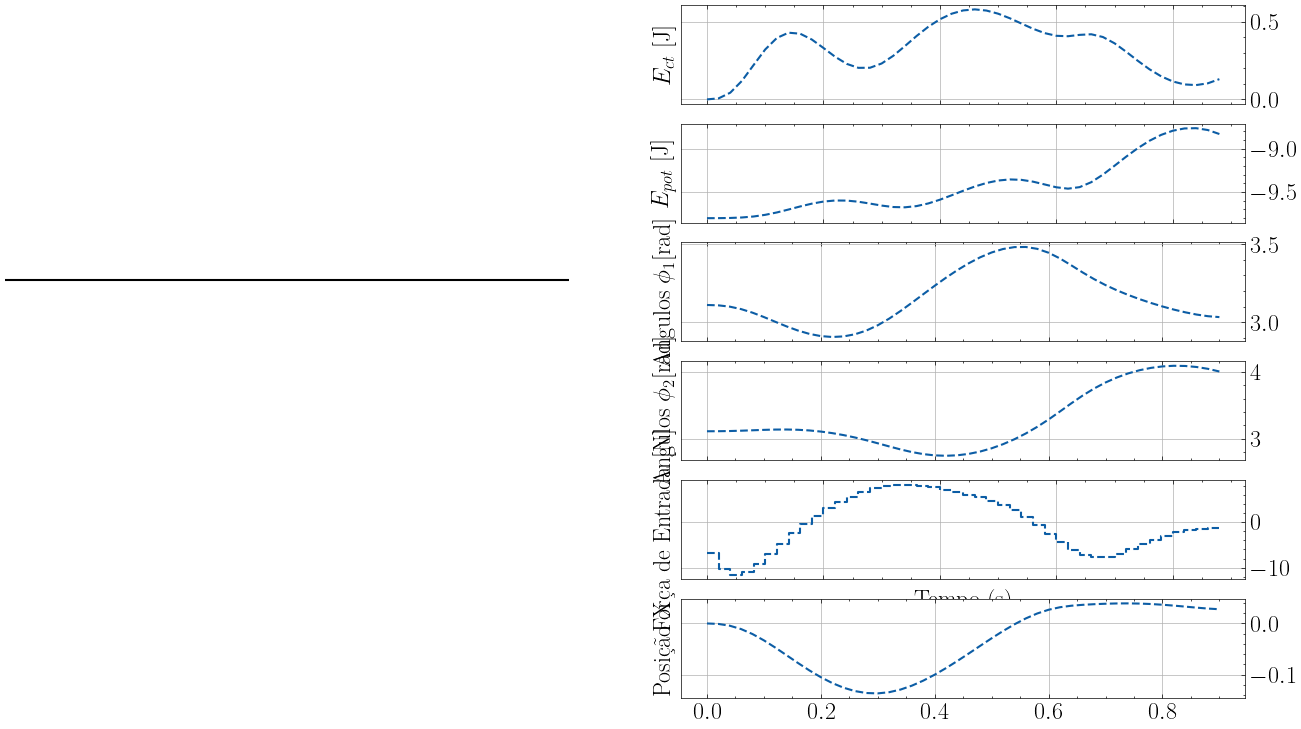

In [1338]:
line1, line2 = pendulum_bars(x0)
#bar1[0].set_data(line1[0],line1[1])
#bar2[0].set_data(line2[0],line2[1])
mpc_graphics.plot_predictions()
mpc_graphics.reset_axes()

fig

In [1339]:
#%%capture
# Quickly reset the history of the MPC data object.
mpc.reset_history()

n_steps = 300
for k in range(n_steps):
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)
    

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     9276
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3074

Total number of variables............................:     1965
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       45
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1896
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.4837451e+02 2.95e-13 1.00e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [1340]:
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

# The function describing the gif:
x_arr = mpc.data['_x']
def update(t_ind):
    line1, line2 = pendulum_bars(x_arr[t_ind])
    bar1[0].set_data(line1[0],line1[1])
    bar2[0].set_data(line2[0],line2[1])
    mpc_graphics.plot_results(t_ind)
    mpc_graphics.plot_predictions(t_ind)
    mpc_graphics.reset_axes()

#anim = FuncAnimation(fig, update, frames=n_steps, repeat=False)
#gif_writer = animation.PillowWriter(fps=30)
#anim.save('doMPC_9CR.gif', writer=gif_writer)

In [1341]:
#Compiler = Xelatex

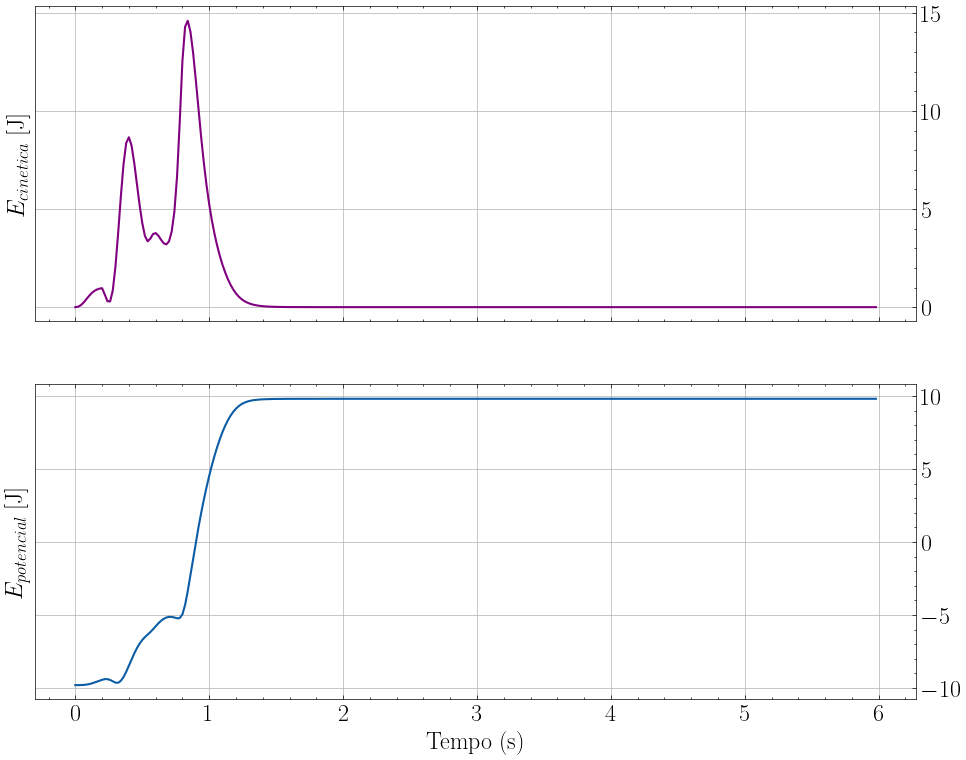

In [1342]:
# Plotar Energias

fig = plt.figure(figsize=(25,9))

ax1 = plt.subplot2grid((2, 2), (0,1))
ax2 = plt.subplot2grid((2, 2), (1,1))

ax1.set_ylabel('$E_{cinetica}$ [J]')
ax2.set_ylabel('$E_{potencial}$ [J]')

# Axis on the right.
for ax in [ax1, ax2]:
    #ax.yaxis.set_label_position("right")
    ax.yaxis.set_label_position("left")
    ax.yaxis.tick_right()
    if ax != ax2:
        ax.xaxis.set_ticklabels([])

ax2.set_xlabel('Tempo (s)')

mpc_graphics.add_line(var_type='_aux', var_name='E_ct', axis=ax1, color ='purple')
mpc_graphics.add_line(var_type='_aux', var_name='E_pot', axis=ax2)
plt.savefig('Cap4_MPC_NL_caso_10_Energias_CR.png', dpi=300, bbox_inches='tight')

plt.show()

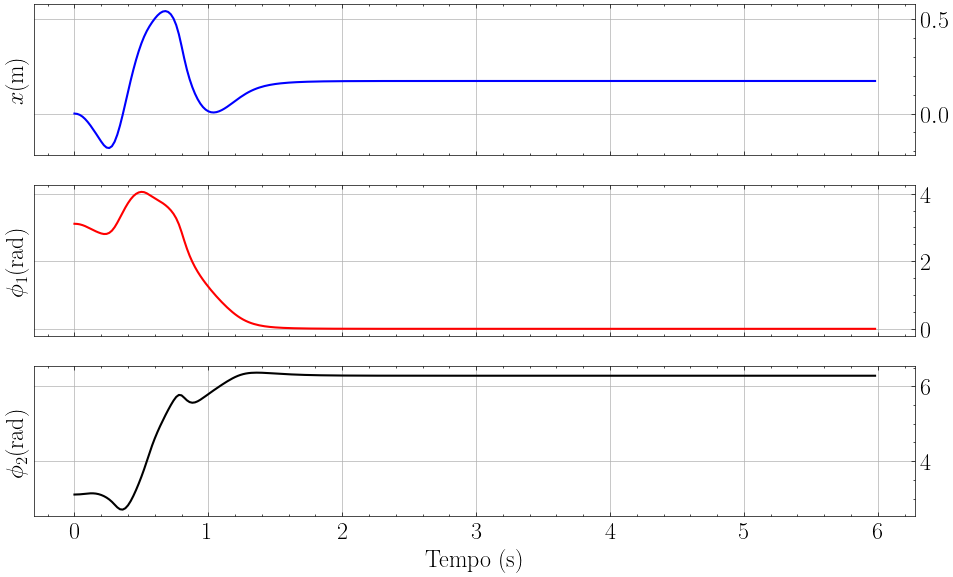

In [1343]:
# Plotar estados

fig = plt.figure(figsize=(25,9))

ax1 = plt.subplot2grid((4, 2), (0,1))
ax2 = plt.subplot2grid((4, 2), (1,1))
ax3 = plt.subplot2grid((4, 2), (2,1))
#ax4 = plt.subplot2grid((4, 2), (3,1))

ax1.set_ylabel('$x$(m)')
ax2.set_ylabel('$\\phi_1$(rad)')
ax3.set_ylabel('$\\phi_2$(rad)')
#ax4.set_ylabel('Sinal u (N)')

# Axis on the right.
for ax in [ax1, ax2, ax3]:
    #ax.yaxis.set_label_position("right")
    ax.yaxis.set_label_position("left")
    ax.yaxis.tick_right()
    if ax != ax3:
        ax.xaxis.set_ticklabels([])

ax3.set_xlabel('Tempo (s)')
mpc_graphics.add_line(var_type='_x', var_name='pos', axis=ax1, color='blue')
mpc_graphics.add_line(var_type='_x', var_name='phi_1', axis=ax2, color='red')
mpc_graphics.add_line(var_type='_x', var_name='phi_2', axis=ax3, color='black')
#mpc_graphics.add_line(var_type='_u', var_name='force', axis=ax4, color='green')
plt.savefig('Cap4_MPC_NL_caso_10_estados_CR.png', dpi=300, bbox_inches='tight')

plt.show()

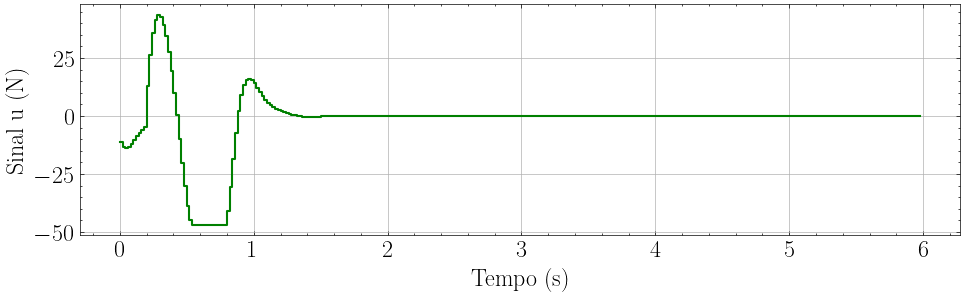

In [1344]:
fig = plt.figure(figsize=(25,3))

ax4 = plt.subplot2grid((1, 2), (0,1))

ax4.set_ylabel('Sinal u (N)')


ax.yaxis.set_label_position("left")
ax.yaxis.tick_right()
ax.xaxis.set_ticklabels([])

ax4.set_xlabel('Tempo (s)')
mpc_graphics.add_line(var_type='_u', var_name='force', axis=ax4, color='green',label='Sinal u $(R=0.01)$')
plt.savefig('Cap4_MPC_NL_caso_10_sinalu_CR.png', dpi=300, bbox_inches='tight')


In [1345]:
mpc_graphics